# Deep Learning with PyTorch

## Autograd: Automatic Differentiation

Central to all neural networks in PyTorch is the `autograd` package. Let’s first briefly visit this, and we will then go to training our first neural network.

The `autograd` package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

Let us see this in more simple terms with some examples.

### Tensor

`torch.Tensor` is the central class of the package. If you set its attribute `.requires_grad` as `True`, it starts to track all operations on it. When you finish your computation you can call `.backward()` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into `.grad` attribute.

To stop a tensor from tracking history, you can call `.detach()` to detach it from the computation history, and to prevent future computation from being tracked.

To prevent tracking history (and using memory), you can also wrap the code block in with `torch.no_grad():`. This can be particularly helpful when evaluating a model because the model may have trainable parameters with `requires_grad=True`, but for which we don’t need the gradients.

There’s one more class which is very important for autograd implementation - a `Function`.

`Tensor` and `Function` are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each tensor has a `.grad_fn` attribute that references a `Function` that has created the `Tensor` (except for Tensors created by the user - their `grad_fn` is `None`).

If you want to compute the derivatives, you can call `.backward()` on a `Tensor`. If `Tensor` is a scalar (i.e. it holds a one element data), you don’t need to specify any arguments to `backward()`, however if it has more elements, you need to specify a gradient argument that is a tensor of matching shape.

In [1]:
import torch

Create a tensor and set `requires_grad=True` to track computation with it

In [2]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Do a tensor operation:

In [3]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


`y` was created as a result of an operation, so it has a `grad_fn`.

In [4]:
print(y.grad_fn)

Do more operations on `y`:

In [5]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


`.requires_grad_( ... )` changes an existing Tensor’s `requires_grad` flag in-place. The input flag defaults to `False` if not given.

In [6]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print("a requires grad:", '\t', a.requires_grad)

a.requires_grad_(True)
print("a requires grad:", '\t', a.requires_grad)

b = (a * a).sum()
print("b grad:", '\t'*2, b.grad_fn)

a requires grad: 	 False
a requires grad: 	 True
b grad: 		 <SumBackward0 object at 0x10bfa5550>


### Gradients

Let’s backprop now. Because out contains a single scalar, `out.backward()` is equivalent to `out.backward(torch.tensor(1.))`.

In [7]:
out.backward()

Print gradients $d(out)/dx$

In [8]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [9]:
#TODO: cleanup LaTex

You should have got a matrix of `4.5`. 

Let’s call the out Tensor “o”. We have that $o=14∑izi, zi=3(xi+2)2$ and $zi∣∣xi=1=27$. Therefore, $∂o/∂xi=32(xi+2)$, hence $∂o/∂xi∣∣xi=1 = 9/2 = 4.5$.

Mathematically, if you have a vector valued function $y⃗ =f(x⃗)$, then the gradient of $y⃗$  with respect to $x⃗$  is a Jacobian matrix:

$J=⎛⎝⎜⎜⎜⎜∂y1∂x1⋮∂ym∂x1⋯⋱⋯∂y1∂xn⋮∂ym∂xn⎞⎠⎟⎟⎟⎟$

Generally speaking, `torch.autograd` is an engine for computing vector-Jacobian product. That is, given any vector $v=(v1v2⋯vm)T$, compute the product $vT⋅J$. If v happens to be the gradient of a scalar function $l=g(y⃗)$, that is, $v=(∂l∂y1⋯∂l∂ym)T$, then by the chain rule, the vector-Jacobian product would be the gradient of l with respect to $x⃗$ :

$JT⋅v=⎛⎝⎜⎜⎜⎜∂y1∂x1⋮∂y1∂xn⋯⋱⋯∂ym∂x1⋮∂ym∂xn⎞⎠⎟⎟⎟⎟⎛⎝⎜⎜⎜⎜∂l∂y1⋮∂l∂ym⎞⎠⎟⎟⎟⎟=⎛⎝⎜⎜⎜⎜∂l∂x1⋮∂l∂xn⎞⎠⎟⎟⎟⎟$

(Note that $vT⋅J$ gives a row vector which can be treated as a column vector by taking $JT⋅v$.)

This characteristic of vector-Jacobian product makes it very convenient to feed external gradients into a model that has non-scalar output.

Now let’s take a look at an example of vector-Jacobian product:

In [10]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([ -565.1685,  -820.6586, -1246.6469], grad_fn=<MulBackward0>)


Now in this case `y` is no longer a scalar. `torch.autograd` could not compute the full Jacobian directly, but if we just want the vector-Jacobian product, simply pass the vector to backward as argument:

In [11]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


You can also stop autograd from tracking history on Tensors with `.requires_grad=True` by wrapping the code block in `with torch.no_grad():`

In [14]:
print("x requires gradient:", "\t", x.requires_grad)
print("x requires gradient:", "\t", (x ** 2).requires_grad)

with torch.no_grad():
    print("x requires gradient:", "\t", (x ** 2).requires_grad)

x requires gradient: 	 True
x requires gradient: 	 True
x requires gradient: 	 False


## Neural Networks

Neural networks can be constructed using the `torch.nn` package.

Now that you had a glimpse of `autograd`, `nn` depends on `autograd` to define models and differentiate them. An `nn.Module` contains layers, and a method `forward(input)` that returns the `output`.

For example, look at this network that classifies digit images:

In [15]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://pytorch.org/tutorials/_images/mnist.png")

It is a simple feed-forward network. It takes the input, feeds it through several layers one after the other, and then finally gives the output.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule: `weight = weight - learning_rate * gradient`


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


You just have to define the `forward` function, and the `backward` function (where gradients are computed) is automatically defined for you using `autograd`. You can use any of the Tensor operations in the `forward` function.

The learnable parameters of a model are returned by `net.parameters()`

In [20]:
params = list(net.parameters())
print("length of nn params:", '\t', len(params))
print("conv1's weight:", '\t', params[0].size())

length of nn params: 	 10
conv1's weight: 	 torch.Size([6, 1, 3, 3])


Let try a random 32x32 input. Note: expected input size of this net (LeNet) is 32x32. To use this net on MNIST dataset, please resize the images from the dataset to 32x32.

In [23]:
input = torch.randn(1, 1, 32, 32)
out = net(input)

print("convnet output:", '\n', out)

convnet output: 
 tensor([[-0.0323,  0.0787, -0.0041, -0.0566, -0.0321,  0.0888, -0.0185,  0.1333,
         -0.0236,  0.0479]], grad_fn=<AddmmBackward>)


Zero the gradient buffers of all parameters and backprops with random gradients:

In [24]:
net.zero_grad()
out.backward(torch.randn(1, 10))

#### * Note

`torch.nn` only supports mini-batches. The entire `torch.nn` package only supports inputs that are a mini-batch of samples, and not a single sample.

For example, `nn.Conv2d` will take in a 4D Tensor of `nSamples x nChannels x Height x Width`.

If you have a single sample, just use `input.unsqueeze(0)` to add a fake batch dimension.

#### * Recap:

`torch.Tensor` - A multi-dimensional array with support for autograd operations like backward(). Also holds the gradient w.r.t. the tensor.

`nn.Module` - Neural network module. Convenient way of encapsulating parameters, with helpers for moving them to GPU, exporting, loading, etc.

`nn.Parameter` - A kind of Tensor, that is automatically registered as a parameter when assigned as an attribute to a Module.

`autograd.Function` - Implements forward and backward definitions of an autograd operation. Every Tensor operation creates at least a single Function node that connects to functions that created a Tensor and encodes its history.

#### * At this point, we covered:
- Defining a neural network
- Processing inputs and calling backward

#### * Still left:
- Computing the loss
- Updating the weights of the network

## Loss Function

A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.

There are several different loss functions under the nn package . A simple loss is: `nn.MSELoss` which computes the mean-squared error between the input and the target.

For example:

In [25]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.5088, grad_fn=<MseLossBackward>)


Now, if you follow `loss` in the backward direction, using its `.grad_fn` attribute, you will see a graph of computations that looks like this:

So, when we call `loss.backward()`, the whole graph is differentiated w.r.t. the loss, and all Tensors in the graph that has `requires_grad=True` will have their `.grad` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:

In [28]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

## Backprop

To backpropagate the error all we have to do is to `loss.backward()`. You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

Now we shall call `loss.backward()`, and have a look at conv1’s bias gradients before and after the backward.

In [29]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0167,  0.0040, -0.0062,  0.0002,  0.0093,  0.0019])


Now, we have seen how to use loss functions.

* Read Later:

The neural network package contains various modules and loss functions that form the building blocks of deep neural networks. A full list with documentation is here: https://pytorch.org/docs/stable/nn.html

The only thing left to learn is:

- Updating the weights of the network

## Update the Weights

The simplest update rule used in practice is the Stochastic Gradient Descent (SGD):

`weight = weight - learning_rate * gradient`

We can implement this using simple python code:

In [30]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. To enable this, we built a small package: torch.optim that implements all these methods. Using it is very simple:

In [31]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

* Note

Observe how gradient buffers had to be manually set to zero using `optimizer.zero_grad()`. This is because gradients are accumulated as explained in **Backprop** section.

## Training a Classifier

### What about data?

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, we have created a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [32]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://pytorch.org/tutorials/_images/cifar10.png")

### Training an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10

Using `torchvision`, it’s extremely easy to load CIFAR10.

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Files already downloaded and verified


Let us show some of the training images, for fun.

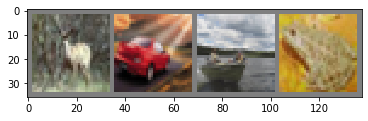

 deer   car  ship  frog


In [39]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [40]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [41]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [42]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.205
[1,  4000] loss: 1.825
[1,  6000] loss: 1.673
[1,  8000] loss: 1.590
[1, 10000] loss: 1.512
[1, 12000] loss: 1.480
[2,  2000] loss: 1.388
[2,  4000] loss: 1.381
[2,  6000] loss: 1.332
[2,  8000] loss: 1.317
[2, 10000] loss: 1.308
[2, 12000] loss: 1.283
Finished Training


### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

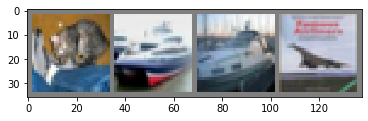

GroundTruth:    cat  ship  ship plane


In [43]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [44]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [45]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [47]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


That looks waaay better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [48]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 47 %
Accuracy of   car : 71 %
Accuracy of  bird : 35 %
Accuracy of   cat : 31 %
Accuracy of  deer : 48 %
Accuracy of   dog : 64 %
Accuracy of  frog : 71 %
Accuracy of horse : 54 %
Accuracy of  ship : 65 %
Accuracy of truck : 64 %


Okay, so what next?

How do we run these neural networks on the GPU?

### Training on GPU

Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu
